<a href="https://colab.research.google.com/github/Haripriya585/MajorProject/blob/main/product_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-surprise


     |████████████████████████████████| 11.8MB 336kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617602 sha256=4639d4ca7915b409cdc5b10f3eaab04e4196cb4db18fcfd1a20b7196c49a9bcf
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from surprise import KNNWithMeans
from surprise import SVD, SVDpp
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV

import time

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project/ratings_Electronics.csv', names=["userId", "productId", "rating", "timestamp"])  
df.head() 

NameError: ignored

In [ ]:
rows_count, columns_count = df.shape
print('Total Number of rows :', rows_count)
print('Total Number of columns :', columns_count)

Total Number of rows : 7824482
Total Number of columns : 4


In [ ]:
df.dtypes

userId        object
productId     object
rating       float64
timestamp      int64
dtype: object

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
unique_userId = df['userId'].nunique()
unique_productId = df['productId'].nunique()
print('Total number of unique Users    : ', unique_userId)
print('Total number of unique Products : ', unique_productId)

Total number of unique Users    :  4201696
Total number of unique Products :  476002


In [ ]:
df.apply(lambda x : sum(x.isnull()))

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [ ]:
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [ ]:
df.isna().any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [ ]:
df_transpose = df.describe().T
df_transpose

count          mean  ...           75%           max
rating     7824482.0  4.012337e+00  ...  5.000000e+00  5.000000e+00
timestamp  7824482.0  1.338178e+09  ...  1.386115e+09  1.406074e+09

[2 rows x 8 columns]

In [ ]:
df_transpose[['min', '25%', '50%', '75%', 'max']]

min           25%           50%           75%           max
rating             1.0  3.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00
timestamp  912729600.0  1.315354e+09  1.361059e+09  1.386115e+09  1.406074e+09

In [ ]:
df['rating'].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: rating, dtype: int64

In [ ]:
rating_counts = pd.DataFrame(df['rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

Labels  Ratings
0     5.0  4347541
1     4.0  1485781
2     1.0   901765
3     3.0   633073
4     2.0   456322

In [ ]:
df = df.drop(['timestamp'], axis=1)

In [ ]:
df1 = df.copy()


In [ ]:
df1.head()

userId   productId  rating
0   AKM1MP6P0OYPR  0132793040     5.0
1  A2CX7LUOHB2NDG  0321732944     5.0
2  A2NWSAGRHCP8N5  0439886341     1.0
3  A2WNBOD3WNDNKT  0439886341     3.0
4  A1GI0U4ZRJA8WN  0439886341     1.0

In [ ]:
users_counts = df1['userId'].value_counts().rename('users_counts')
users_data   = df1.merge(users_counts.to_frame(),
                                left_on='userId',
                                right_index=True)

In [ ]:
subset_df = users_data[users_data.users_counts >= 50]
subset_df


userId   productId  rating  users_counts
94       A3BY5KCNQZXV5U  0594451647     5.0            50
14863    A3BY5KCNQZXV5U  B00000JD4V     4.0            50
134213   A3BY5KCNQZXV5U  B000063574     5.0            50
338368   A3BY5KCNQZXV5U  B0000CDJP8     5.0            50
634048   A3BY5KCNQZXV5U  B0007Y794O     5.0            50
...                 ...         ...     ...           ...
7811895  A328S9RN3U5M68  B00JGL37FO     5.0            76
7817686  A328S9RN3U5M68  B00K00FN3O     5.0            76
7824063  A328S9RN3U5M68  B00L21HC7A     5.0            76
7824081  A328S9RN3U5M68  B00L2442H0     5.0            76
7824103  A328S9RN3U5M68  B00L26YDA4     5.0            76

[125871 rows x 4 columns]

In [ ]:
product_rating_counts = subset_df['productId'].value_counts().rename('product_rating_counts')
product_rating_data   = subset_df.merge(product_rating_counts.to_frame(),
                                left_on='productId',
                                right_index=True)

In [ ]:
product_rating_data = product_rating_data[product_rating_data.product_rating_counts >= 10]
product_rating_data

userId   productId  ...  users_counts  product_rating_counts
634048   A3BY5KCNQZXV5U  B0007Y794O  ...            50                     18
633970    AKT8TGIT6VVZ5  B0007Y794O  ...           192                     18
633944   A1ILWPH1GHUXE2  B0007Y794O  ...            98                     18
634073    A1ZM846Y7AUYD  B0007Y794O  ...            77                     18
633998   A2ED50E3KWKUKW  B0007Y794O  ...            65                     18
...                 ...         ...  ...           ...                    ...
7667497   AWPN47SSWK1JV  B00FZ9SMVU  ...            51                     10
7667517  A2MJ8OL2FYN7CW  B00FZ9SMVU  ...            81                     10
7667443  A1GWG5CWLKJ7ET  B00FZ9SMVU  ...            75                     10
7667539  A3VBZDYGHF4NK8  B00FZ9SMVU  ...            66                     10
7667532  A2CWIYIETNBAK3  B00FZ9SMVU  ...            55                     10

[42941 rows x 5 columns]

In [ ]:
electronics_data_df = product_rating_data.copy()

In [ ]:
panda_data = electronics_data_df.drop(['users_counts', 'product_rating_counts'], axis=1)

In [ ]:
panda_data.head()

userId   productId  rating
634048  A3BY5KCNQZXV5U  B0007Y794O     5.0
633970   AKT8TGIT6VVZ5  B0007Y794O     5.0
633944  A1ILWPH1GHUXE2  B0007Y794O     4.0
634073   A1ZM846Y7AUYD  B0007Y794O     4.0
633998  A2ED50E3KWKUKW  B0007Y794O     5.0

In [ ]:
k = 5

In [ ]:
reader = Reader(rating_scale=(1, 5))
reader

In [ ]:
surprise_data = Dataset.load_from_df(panda_data[['userId', 'productId', 'rating']], reader)
surprise_data

In [ ]:
trainset, testset = train_test_split(surprise_data, test_size=.30, random_state=7)
trainset
# testset

In [ ]:
#
panda_data.groupby('productId')['rating'].mean().head()

productId
B00001P4XA    4.000000
B00001P4ZH    4.470588
B00001WRSJ    4.500000
B00001ZWXA    4.600000
B00004SABB    4.000000
Name: rating, dtype: float64

In [ ]:
panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False).head()

productId
B00L3YHF6O    5.0
B00006HSML    5.0
B001TH7GUA    5.0
B000IJY8DS    5.0
B005LDLP8W    5.0
Name: rating, dtype: float64

In [ ]:
prod_rating_count = pd.DataFrame(panda_data.groupby('productId')['rating'].mean().sort_values(ascending=False))
prod_rating_count['prod_rating_count'] = pd.DataFrame(panda_data.groupby('productId')['rating'].count())


In [ ]:
basic_poplurity_model = prod_rating_count.sort_values(by=['prod_rating_count'], ascending=False)

rating  prod_rating_count
productId                              
B0088CJT4U  4.218447                206
B003ES5ZUU  4.864130                184
B000N99BBC  4.772455                167
B007WTAJTO  4.701220                164
B00829TIEK  4.436242                149

In [ ]:
#Ranking based Algorithms
#Count of user_id for each unique song as recommendation score 
panda_data_grouped = panda_data.groupby('productId').agg({'userId': 'count'}).reset_index()
print(panda_data_grouped)
panda_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
panda_data_grouped

       productId  userId
0     B00001P4XA      12
1     B00001P4ZH      17
2     B00001WRSJ      16
3     B00001ZWXA      10
4     B00004SABB      13
...          ...     ...
2258  B00KVNY2KA      10
2259  B00L21HC7A      16
2260  B00L2442H0      12
2261  B00L26YDA4      13
2262  B00L3YHF6O      14

[2263 rows x 2 columns]


productId  score
0     B00001P4XA     12
1     B00001P4ZH     17
2     B00001WRSJ     16
3     B00001ZWXA     10
4     B00004SABB     13
...          ...    ...
2258  B00KVNY2KA     10
2259  B00L21HC7A     16
2260  B00L2442H0     12
2261  B00L26YDA4     13
2262  B00L3YHF6O     14

[2263 rows x 2 columns]

In [ ]:
panda_data_sort = panda_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
panda_data_sort['Rank'] = panda_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = panda_data_sort.head(k) 
popularity_recommendations 

productId  score  Rank
1592  B0088CJT4U    206   1.0
839   B003ES5ZUU    184   2.0
226   B000N99BBC    167   3.0
1552  B007WTAJTO    164   4.0
1577  B00829TIEK    149   5.0

In [ ]:
# Using popularity based recommender model to make predictions
import warnings
warnings.filterwarnings('ignore')
def recommend(userId):     
    user_recommendations = popularity_recommendations 
    # print(user_recommendations)
    #Adding user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = userId 
      
    #Bringing user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [ ]:
find_recom = [15,121,55,230,344]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 15

      userID   productId  score  Rank
1592      15  B0088CJT4U    206   1.0
839       15  B003ES5ZUU    184   2.0
226       15  B000N99BBC    167   3.0
1552      15  B007WTAJTO    164   4.0
1577      15  B00829TIEK    149   5.0


Here is the recommendation for the userId: 121

      userID   productId  score  Rank
1592     121  B0088CJT4U    206   1.0
839      121  B003ES5ZUU    184   2.0
226      121  B000N99BBC    167   3.0
1552     121  B007WTAJTO    164   4.0
1577     121  B00829TIEK    149   5.0


Here is the recommendation for the userId: 55

      userID   productId  score  Rank
1592      55  B0088CJT4U    206   1.0
839       55  B003ES5ZUU    184   2.0
226       55  B000N99BBC    167   3.0
1552      55  B007WTAJTO    164   4.0
1577      55  B00829TIEK    149   5.0


Here is the recommendation for the userId: 230

      userID   productId  score  Rank
1592     230  B0088CJT4U    206   1.0
839      230  B003ES5ZUU    184   2.0
226   

In [ ]:
cv_results = []  # to store cross validation result 

In [ ]:
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.007, 0.009, 0.01], 'reg_all': [0.4, 0.6]}

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)

svd_gs.fit(surprise_data)
svdpp_gs.fit(surprise_data)

# best RMSE score
print(svd_gs.best_score['rmse'])
print(svdpp_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(svd_gs.best_params['rmse'])
print(svdpp_gs.best_params['rmse'])

0.8703917968272747
0.8702053221280925
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}


In [ ]:
start_time = time.time()

# Creating Model using best parameters
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)

# Training the algorithm on the trainset
svd_model.fit(trainset)


# Predicting for test set
predictions_svd = svd_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVD on 5 split(s) by cross validation
svd_cv = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svd_df = pd.DataFrame.from_dict(svd_cv)
svd_described = svd_df.describe()
cv_results = pd.DataFrame([['SVD', svd_described['test_rmse']['mean'], svd_described['test_mae']['mean'], 
                           svd_described['fit_time']['mean'], svd_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])


# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svd, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8631  0.8851  0.8703  0.8745  0.8847  0.8756  0.0085  
MAE (testset)     0.6409  0.6487  0.6492  0.6453  0.6481  0.6464  0.0031  
Fit time          2.08    2.05    2.12    2.06    2.08    2.08    0.02    
Test time         0.08    0.07    0.07    0.07    0.08    0.08    0.00    


==================== Model Evaluation ===============================
RMSE: 0.8800

 Computational Time : 13.348s


Model      RMSE       MAE  Fit Time  Test Time
0   SVD  0.875558  0.646441  2.077628   0.076862

In [ ]:
start_time = time.time()

# Creating Model using best parameters
svdpp_model = SVDpp(n_epochs=25, lr_all=0.01, reg_all=0.4)

# Training the algorithm on the trainset
svdpp_model.fit(trainset)


# Predicting for test set
predictions_svdpp = svdpp_model.test(testset)

# Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s) by cross validation
svdpp_cv = cross_validate(svdpp_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
svdpp_df = pd.DataFrame.from_dict(svdpp_cv)
svdpp_described = svdpp_df.describe()
svdpp_cv_results = pd.DataFrame([['SVDpp', svdpp_described['test_rmse']['mean'], svdpp_described['test_mae']['mean'], 
                           svdpp_described['fit_time']['mean'], svdpp_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(svdpp_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(predictions_svdpp, verbose=True)
print("=====================================================================")
computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8660  0.8771  0.8693  0.8793  0.8591  0.8702  0.0074  
MAE (testset)     0.6453  0.6498  0.6442  0.6454  0.6326  0.6435  0.0058  
Fit time          23.50   23.10   23.04   23.04   23.09   23.16   0.18    
Test time         0.80    0.66    0.57    0.73    0.67    0.69    0.08    


==================== Model Evaluation ===============================
RMSE: 0.8771

 Computational Time : 139.410s


Model      RMSE       MAE   Fit Time  Test Time
0    SVD  0.875558  0.646441   2.077628   0.076862
1  SVDpp  0.870180  0.643463  23.155442   0.687699

In [ ]:
start_time = time.time()

knn_param_grid = {'bsl_options': {'method': ['als', 'sgd'],
                              'reg': [1, 2]},
              'k': [15, 20, 25, 30, 40, 50, 60],
              'sim_options': {'name': ['msd', 'cosine', 'pearson_baseline']}
              }

knnbasic_gs = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnmeans_gs = GridSearchCV(KNNWithMeans, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)
knnz_gs     = GridSearchCV(KNNWithZScore, knn_param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=5)


knnbasic_gs.fit(surprise_data)
knnmeans_gs.fit(surprise_data)
knnz_gs.fit(surprise_data)

# best RMSE score
print(knnbasic_gs.best_score['rmse'])
print(knnmeans_gs.best_score['rmse'])
print(knnz_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(knnbasic_gs.best_params['rmse'])
print(knnmeans_gs.best_params['rmse'])
print(knnz_gs.best_params['rmse'])

computational_time = time.time() - start_time
print('\nComputational Time : %0.3fs' %(computational_time))

0.9625572468713924
0.9149135821479419
0.9249119679188551
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'bsl_options': {'method': 'als', 'reg': 1}, 'k': 60, 'sim_options': {'name': 'cosine', 'user_based': True}}

Computational Time : 1616.806s


In [ ]:
start_time = time.time()

# Creating Model using best parameters
knnBasic_model = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnBasic_model.fit(trainset)

# Predicting for test set
prediction_knnBasic = knnBasic_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s)
knnBasic_cv = cross_validate(knnBasic_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnBasic_df = pd.DataFrame.from_dict(knnBasic_cv)
knnBasic_described = knnBasic_df.describe()
knnBasic_cv_results = pd.DataFrame([['KNNBasic', knnBasic_described['test_rmse']['mean'], knnBasic_described['test_mae']['mean'], 
                           knnBasic_described['fit_time']['mean'], knnBasic_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnBasic_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnBasic, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9805  0.9843  0.9779  0.9713  0.9857  0.9799  0.0051  
MAE (testset)     0.6990  0.7015  0.6942  0.6923  0.7003  0.6975  0.0036  
Fit time          0.86    0.88    0.82    0.84    0.82    0.84    0.02    
Test time         0.56    0.55    0.56    0.76    0.56    0.60    0.08    


==================== Model Evaluation ===============================
RMSE: 1.0018

 Computational Time : 9.

Model      RMSE       MAE   Fit Time  Test Time
0       SVD  0.875563  0.646161   2.127217   0.108616
1     SVDpp  0.869857  0.642879  23.593963   0.650539
2     SVDpp  0.871106  0.644059  23.695830   0.678010
3  KNNBasic  0.979941  0.697464   0.842754   0.595808

In [ ]:
start_time = time.time()

# Creating Model using best parameters
knnZscore_model = KNNWithZScore(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnZscore_model.fit(trainset)

# Predicting for testset
prediction_knnZscore = knnZscore_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s)
knnZscore_cv = cross_validate(knnZscore_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnZscore_df = pd.DataFrame.from_dict(knnZscore_cv)
knnZscore_described = knnZscore_df.describe()
knnZscore_cv_results = pd.DataFrame([['KNNWithZScore', knnZscore_described['test_rmse']['mean'], knnZscore_described['test_mae']['mean'], 
                           knnZscore_described['fit_time']['mean'], knnZscore_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnZscore_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnZscore, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9245  0.9259  0.9241  0.9364  0.9551  0.9332  0.0119  
MAE (testset)     0.6446  0.6458  0.6435  0.6515  0.6673  0.6506  0.0088  
Fit time          0.94    0.96    0.97    0.99    0.96    0.96    0.02    
Test time         0.64    0.64    0.65    0.63    0.62    0.64    0.01    


==================== Model Evaluation ===============================
RMSE: 0.9541

 Computational Time

Model      RMSE       MAE   Fit Time  Test Time
0            SVD  0.875563  0.646161   2.127217   0.108616
1          SVDpp  0.869857  0.642879  23.593963   0.650539
2          SVDpp  0.871106  0.644059  23.695830   0.678010
3       KNNBasic  0.979941  0.697464   0.842754   0.595808
4  KNNWithZScore  0.933199  0.650557   0.963014   0.635482

In [ ]:
start_time = time.time()

# Creating Model using best parameters
knnMeansUU_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': True})

# Training the algorithm on the trainset
knnMeansUU_model.fit(trainset)

# Predicting for testset
prediction_knnMeansUU = knnMeansUU_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans User-User on 5 split(s)
knnMeansUU_cv = cross_validate(knnMeansUU_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansUU_df = pd.DataFrame.from_dict(knnMeansUU_cv)
knnMeansUU_described = knnMeansUU_df.describe()
knnMeansUU_cv_results = pd.DataFrame([['KNNWithMeans User-User', knnMeansUU_described['test_rmse']['mean'], knnMeansUU_described['test_mae']['mean'], 
                           knnMeansUU_described['fit_time']['mean'], knnMeansUU_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansUU_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansUU, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9084  0.9371  0.8830  0.9366  0.9103  0.9151  0.0202  
MAE (testset)     0.6383  0.6577  0.6303  0.6511  0.6412  0.6437  0.0097  
Fit time          0.50    0.50    0.52    0.52    0.52    0.51    0.01    
Test time         0.43    0.43    0.45    0.64    0.42    0.47    0.08    


==================== Model Evaluation ===============================
RMSE: 0.9364

 Computational Time 

Model      RMSE       MAE   Fit Time  Test Time
0                     SVD  0.875563  0.646161   2.127217   0.108616
1                   SVDpp  0.869857  0.642879  23.593963   0.650539
2                   SVDpp  0.871106  0.644059  23.695830   0.678010
3                KNNBasic  0.979941  0.697464   0.842754   0.595808
4           KNNWithZScore  0.933199  0.650557   0.963014   0.635482
5  KNNWithMeans User-User  0.915091  0.643722   0.511450   0.474282

In [ ]:
start_time = time.time()

# Creating Model using best parameters
knnMeansII_model = KNNWithMeans(k=60, sim_options={'name': 'cosine', 'user_based': False})

# Training the algorithm on the trainset
knnMeansII_model.fit(trainset)

# Predicting for testset
prediction_knnMeansII = knnMeansII_model.test(testset)

# Evaluating RMSE, MAE of algorithm KNNWithMeans Item-Item on 5 split(s)
knnMeansII_cv = cross_validate(knnMeansII_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Storing Crossvalidation Results in dataframe
knnMeansII_df = pd.DataFrame.from_dict(knnMeansII_cv)
knnMeansII_described = knnMeansII_df.describe()
knnMeansII_cv_results = pd.DataFrame([['KNNWithMeans Item-Item', knnMeansII_described['test_rmse']['mean'], knnMeansII_described['test_mae']['mean'], 
                           knnMeansII_described['fit_time']['mean'], knnMeansII_described['test_time']['mean']]],
                            columns = ['Model', 'RMSE', 'MAE', 'Fit Time', 'Test Time'])

cv_results = cv_results.append(knnMeansII_cv_results, ignore_index=True)

# get RMSE
print("\n\n==================== Model Evaluation ===============================")
accuracy.rmse(prediction_knnMeansII, verbose=True)
print("=====================================================================")

computational_time = time.time() - start_time
print('\n Computational Time : %0.3fs' %(computational_time))
cv_results


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9189  0.9071  0.9277  0.9353  0.9145  0.9207  0.0099  
MAE (testset)     0.6485  0.6440  0.6483  0.6570  0.6435  0.6482  0.0048  
Fit time          0.89    0.88    0.90    0.87    0.87    0.88    0.01    
Test time         0.60    0.57    0.57    0.57    0.80    0.62    0.09    


==================== Model Evaluation ===============================
RMSE: 0.9450

 Computational Time 

Model      RMSE       MAE   Fit Time  Test Time
0                     SVD  0.875563  0.646161   2.127217   0.108616
1                   SVDpp  0.869857  0.642879  23.593963   0.650539
2                   SVDpp  0.871106  0.644059  23.695830   0.678010
3                KNNBasic  0.979941  0.697464   0.842754   0.595808
4           KNNWithZScore  0.933199  0.650557   0.963014   0.635482
5  KNNWithMeans User-User  0.915091  0.643722   0.511450   0.474282
6  KNNWithMeans Item-Item  0.920715  0.648249   0.881113   0.620112

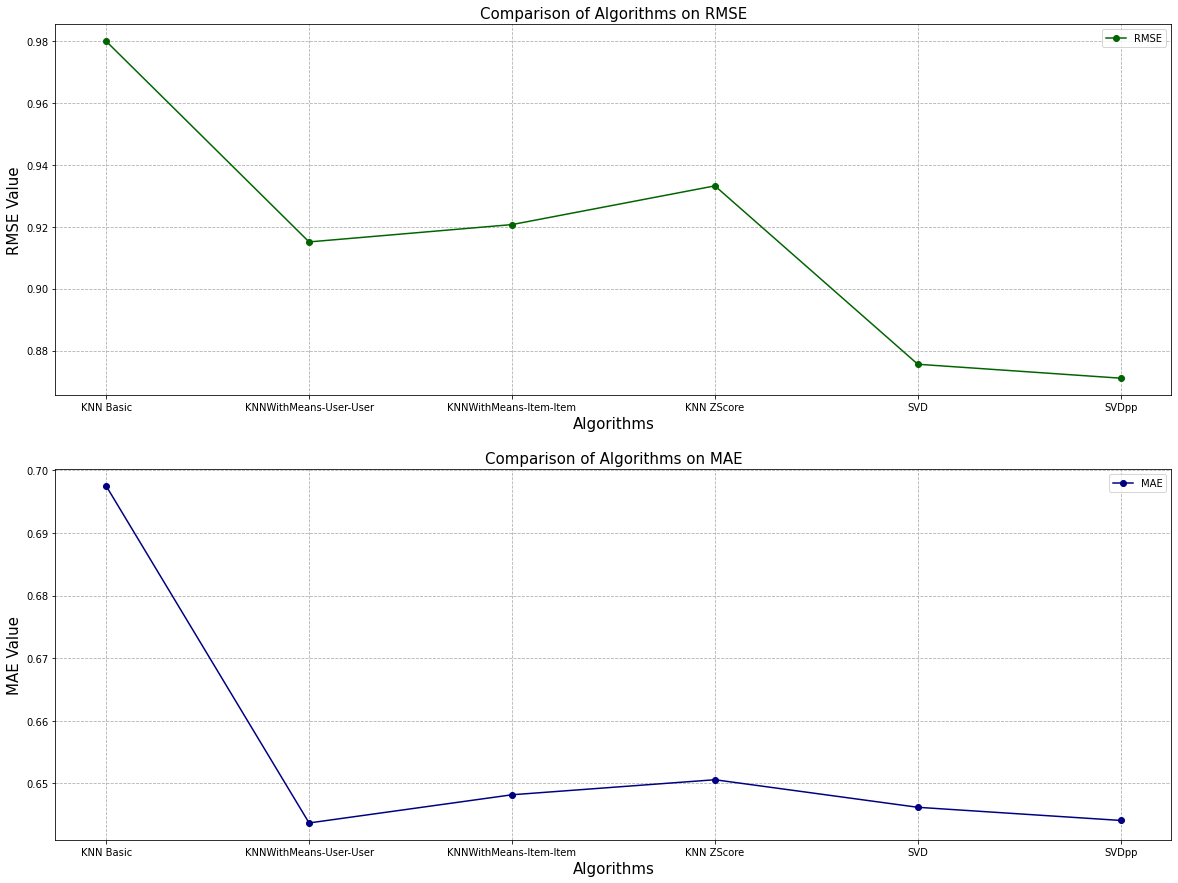

Model      RMSE       MAE   Fit Time  Test Time
0                     SVD  0.875563  0.646161   2.127217   0.108616
1                   SVDpp  0.869857  0.642879  23.593963   0.650539
2                   SVDpp  0.871106  0.644059  23.695830   0.678010
3                KNNBasic  0.979941  0.697464   0.842754   0.595808
4           KNNWithZScore  0.933199  0.650557   0.963014   0.635482
5  KNNWithMeans User-User  0.915091  0.643722   0.511450   0.474282
6  KNNWithMeans Item-Item  0.920715  0.648249   0.881113   0.620112

In [ ]:
x_algo = ['KNN Basic', 'KNNWithMeans-User-User', 'KNNWithMeans-Item-Item', 'KNN ZScore', 'SVD', 'SVDpp']
all_algos_cv = [knnBasic_cv, knnMeansUU_cv, knnMeansII_cv, knnZscore_cv, svd_cv, svdpp_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv  = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,15))

plt.subplot(2, 1, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(2, 1, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()

cv_results

In [ ]:
import collections

top_n = collections.defaultdict(list)
print(top_n)
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = collections.defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions_svd, n=5)
top_n

defaultdict(<class 'list'>, {})


defaultdict(list,
            {'AZBXKUH4AIW3X': [('B005LDLP8W', 4.83305308085889),
              ('B00029U1DK', 4.744519998881406),
              ('B00316263Y', 4.712603120710117),
              ('B000BSN4UY', 4.665844866515709),
              ('B0058UUR6E', 4.625456853587876)],
             'A1T1YSCDW0PD25': [('B004S4R5CK', 4.89642754312328),
              ('B0002SQ2P2', 4.80131340548855),
              ('B000CKVOOY', 4.775353972000991),
              ('B006TF36TM', 4.773985150830457),
              ('B0099SMFVQ', 4.7650149752546085)],
             'A1HYH206E18XVC': [('B006EKIQYM', 4.518903063483871),
              ('B003YKG2UK', 4.3078113341653985),
              ('B00CE590Z0', 4.1913290640047185),
              ('B002VPE1XY', 4.1802740084944165),
              ('B005DM9BGE', 4.076269451807289)],
             'A2ZFFSJ0VM6KSJ': [('B00AAIPT76', 4.795913411088806),
              ('B008AST7R6', 4.791809238721124),
              ('B007I5JT4S', 4.7178560951283535),
              ('B005DOK8

In [ ]:
#from scipy.linalg import svd
from surprise import SVD,NormalPredictor
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


kf = KFold(n_splits=5)
svd_model = SVD(n_epochs=20, lr_all=0.005, reg_all=0.2)
precs = []
recalls = []

for trainset, testset in kf.split(surprise_data):
    svd_model.fit(trainset)
    predictions = svd_model.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=3.5)

    # Precision and recall can then be averaged over all users
    print('Precision : ', sum(prec for prec in precisions.values()) / len(precisions))
    print('recalls : ',sum(rec for rec in recalls.values()) / len(recalls))

Precision :  0.8806164383561622
recalls :  0.8359755118260166
Precision :  0.8718895078922915
recalls :  0.8277934172915672
Precision :  0.8788942417985758
recalls :  0.8366061955947479
Precision :  0.8743748566184883
recalls :  0.8312824080333063
Precision :  0.8687671232876699
recalls :  0.8279197310288874
